<a href="https://colab.research.google.com/github/seiji0203/Machine-Learning-Models/blob/master/%E3%83%AD%E3%82%B8%E3%82%B9%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [235]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFE

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
os.chdir('/content/drive/My Drive/Colab Notebooks/ML/titanic')

In [180]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [181]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [182]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [183]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [184]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


#データ前処理

In [185]:
# まずtest dataのPassengerIdを保存
PassengerId = test['PassengerId']

In [186]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [187]:
# train dataののSurvivedを分離してtest dataと結合
y = train['Survived']
train = train[[col for col in train.columns if col != 'Survived']]

In [191]:
X = pd.concat([train, test], axis=0)

In [192]:
print(train.shape)
print(test.shape)

(891, 11)
(418, 11)


In [193]:
print(X.shape)

(1309, 11)


In [194]:
# 欠損地の確認
X.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [198]:
# 性別について（男性：0, 女性：1）
def code_transform(x):
  if x == 'male':
    y = 0
  else:
    y = 1
  return y

X['Sex'] = X['Sex'].apply(lambda x: code_transform(x))
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [199]:
# embarked 「0：C、1：Q、2：S」に変換
def code_transform(x):
  if x == 'C':
    y = 0
  elif x == 'Q':
    y = 1
  else:
    y = 2
  return y

X['Embarked'] = X['Embarked'].apply(lambda x: code_transform(x))
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,2
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2


In [204]:
# 数値の列と文字の列を調べる
numerical_col = [col for col in X.columns if X[col].dtype != 'object']
categorical_col = [col for col in X.columns if X[col].dtype == 'object']

print(numerical_col)
print(categorical_col)

['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
['Name', 'Ticket', 'Cabin']


In [205]:
# 数値カラムと文字カラムを別々に処理するために分離
X_num = X[numerical_col]
X_cat = X[categorical_col]

print(X_num.shape)
print(X_cat.shape)

(1309, 8)
(1309, 3)


In [206]:
X_num.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,1,22.0,1,0,7.2500,2
1,2,1,1,38.0,1,0,71.2833,0
2,3,3,1,26.0,0,0,7.9250,2
3,4,1,1,35.0,1,0,53.1000,2
4,5,3,1,35.0,0,0,8.0500,2


In [207]:
# 欠損値を各列の中央値で埋める
X_num.fillna(X_num.median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [208]:
X_num.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [209]:
X_cat.head()

,Name,Ticket,Cabin
0,"Braund, Mr. Owen Harris",A/5 21171,NaN
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85
2,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123
4,"Allen, Mr. William Henry",373450,NaN


In [210]:
X_cat.fillna(value='missing', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [211]:
X_cat.isnull().sum()

Name      0
Ticket    0
Cabin     0
dtype: int64

In [212]:
# One-Hot-Encodingで文字列を全て数値に変換
X_cat = pd.get_dummies(X_cat)
print(X_cat.shape)
X_cat.head()

(1309, 2423)


,"Name_Abbing, Mr. Anthony","Name_Abbott, Master. Eugene Joseph","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelseth, Miss. Karen Marie","Name_Abelseth, Mr. Olaus Jorgensen","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Abrahamsson, Mr. Abraham August Johannes","Name_Abrahim, Mrs. Joseph (Sophie Halaut Easu)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Master. Philip Frank","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem","Name_Aldworth, Mr. Charles Augustus","Name_Alexander, Mr. William","Name_Alhomaki, Mr. Ilmari Rudolf","Name_Ali, Mr. Ahmed","Name_Ali, Mr. William","Name_Allen, Miss. Elisabeth Walton","Name_Allen, Mr. William Henry","Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mr. Hudson Joshua Creighton","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Name_Allum, Mr. Owen George","Name_Andersen, Mr. Albert Karvin","Name_Andersen-Jensen, Miss. Carla Christine Nielsine","Name_Anderson, Mr. Harry","Name_Andersson, Master. Sigvard Harald Elias","Name_Andersson, Miss. Ebba Iris Alfrida","Name_Andersson, Miss. Ellis Anna Maria","Name_Andersson, Miss. Erna Alexandra","Name_Andersson, Miss. Ida Augusta Margareta","Name_Andersson, Miss. Ingeborg Constanzia","Name_Andersson, Miss. Sigrid Elisabeth","Name_Andersson, Mr. Anders Johan","Name_Andersson, Mr. August Edvard (""Wennerstrom"")",...,Cabin_E10,Cabin_E101,Cabin_E12,Cabin_E121,Cabin_E17,Cabin_E24,Cabin_E25,Cabin_E31,Cabin_E33,Cabin_E34,Cabin_E36,Cabin_E38,Cabin_E39 E41,Cabin_E40,Cabin_E44,Cabin_E45,Cabin_E46,Cabin_E49,Cabin_E50,Cabin_E52,Cabin_E58,Cabin_E60,Cabin_E63,Cabin_E67,Cabin_E68,Cabin_E77,Cabin_E8,Cabin_F,Cabin_F E46,Cabin_F E57,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Cabin_missing
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [214]:
# X_num, X_catが全て数値データになったので結合して全データを表示
X_total = pd.concat([X_num, X_cat], axis=1)
print(X_total.shape)
X_total.head()

(1309, 2431)


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,"Name_Abbing, Mr. Anthony","Name_Abbott, Master. Eugene Joseph","Name_Abbott, Mr. Rossmore Edward","Name_Abbott, Mrs. Stanton (Rosa Hunt)","Name_Abelseth, Miss. Karen Marie","Name_Abelseth, Mr. Olaus Jorgensen","Name_Abelson, Mr. Samuel","Name_Abelson, Mrs. Samuel (Hannah Wizosky)","Name_Abrahamsson, Mr. Abraham August Johannes","Name_Abrahim, Mrs. Joseph (Sophie Halaut Easu)","Name_Adahl, Mr. Mauritz Nils Martin","Name_Adams, Mr. John","Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)","Name_Aks, Master. Philip Frank","Name_Aks, Mrs. Sam (Leah Rosen)","Name_Albimona, Mr. Nassef Cassem","Name_Aldworth, Mr. Charles Augustus","Name_Alexander, Mr. William","Name_Alhomaki, Mr. Ilmari Rudolf","Name_Ali, Mr. Ahmed","Name_Ali, Mr. William","Name_Allen, Miss. Elisabeth Walton","Name_Allen, Mr. William Henry","Name_Allison, Master. Hudson Trevor","Name_Allison, Miss. Helen Loraine","Name_Allison, Mr. Hudson Joshua Creighton","Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Name_Allum, Mr. Owen George","Name_Andersen, Mr. Albert Karvin","Name_Andersen-Jensen, Miss. Carla Christine Nielsine","Name_Anderson, Mr. Harry","Name_Andersson, Master. Sigvard Harald Elias",...,Cabin_E10,Cabin_E101,Cabin_E12,Cabin_E121,Cabin_E17,Cabin_E24,Cabin_E25,Cabin_E31,Cabin_E33,Cabin_E34,Cabin_E36,Cabin_E38,Cabin_E39 E41,Cabin_E40,Cabin_E44,Cabin_E45,Cabin_E46,Cabin_E49,Cabin_E50,Cabin_E52,Cabin_E58,Cabin_E60,Cabin_E63,Cabin_E67,Cabin_E68,Cabin_E77,Cabin_E8,Cabin_F,Cabin_F E46,Cabin_F E57,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Cabin_missing
0,1,3,1,22.0,1,0,7.2500,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,3,1,26.0,0,0,7.9250,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,3,1,35.0,0,0,8.0500,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [218]:
# train data の抽出
train_rows = train.shape[0]
X = X_total[:train_rows]

std = StandardScaler()
X = std.fit_transform(X)

print(X.shape)
print(y.shape)

(891, 2431)
(891,)


In [227]:
# モデルの作成
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(623, 2431)
(623,)
(268, 2431)
(268,)


In [228]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [229]:
# y_probaに[ : , 1]を指定することで、Class1（Survived=1）になる確率を予測
y_proba = logreg.predict_proba(X_test)[:, 1]
print(y_proba[:5])

[0.15135804 0.12267748 0.09495211 0.34602134 0.6795456 ]


In [230]:
# y_predは0.5よりも大きければ1を、小さければ0を振り分け
y_pred = logreg.predict(X_test)
print(y_pred[:5])

[0 0 0 0 1]


accuracy: 0.6753731343283582
f1_score: 0.423841059602649


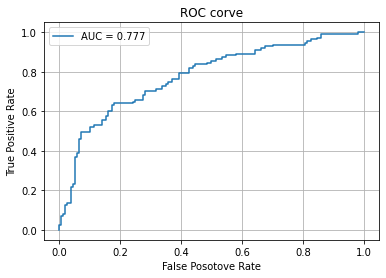

In [231]:
# ROC曲線ととAUCを用いて性能評価
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC corve')
plt.xlabel('False Posotove Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

print('accuracy:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.95      0.77       157
           1       0.80      0.29      0.42       111

    accuracy                           0.68       268
   macro avg       0.73      0.62      0.60       268
weighted avg       0.71      0.68      0.63       268



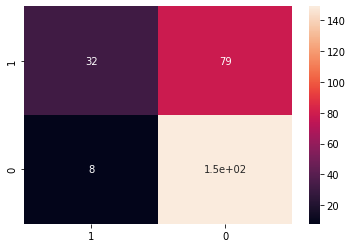

In [236]:
# 混合行列での評価
classes = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=classes)

cmdf = pd.DataFrame(cm, index=classes, columns=classes)

sns.heatmap(cmdf, annot=True)
print(classification_report(y_test, y_pred))